In [1]:
import pyart
import numpy.ma as ma
import numpy as np
from scipy.stats import mstats
from statistics import mean
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import colors as c
from matplotlib.colors import ListedColormap,BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.geodesic as cargeo
from shapely.geometry import Polygon
import os
import warnings
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\Admin\anaconda3\envs\pyart_env\lib\site-packages\wradlib\io\radolan.py:939: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "add_offset": np.float(0),
C:\Users\Admin\anaconda3\envs\pyart_env\lib\site-packages\wradlib\io\radolan.py:948: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "add_offset": np.float(0),
C:\Users\Admin\anaconda3

# Main Class

In [2]:
class RAW:
    def __init__(self,radar,shape_grid,lat_0, lon_0):
        self.radar = radar
        self.shape = shape_grid
        self.lat_0 = lat_0
        self.lon_0 = lon_0
    def noise_rejection(self):
        #reject noise radar
        range_bins=self.radar.range['data']
        ref_last_bins=self.radar.fields['reflectivity']['data'][:,-5:]
        Z_f=mstats.mode(ref_last_bins,axis=None)[0][0]
        Z_s=pyart.retrieve.compute_noisedBZ(1800, noisedBZ_val=Z_f, _range=range_bins, ref_dist=300., noise_field='noise_dbz')
        Z_splus4=Z_s['data']+4
        conditions_masked=ma.masked_less(self.radar.fields['reflectivity']['data'],Z_splus4)
        #mask Z<0
        self.radar.add_field_like('reflectivity', 'reflectivity_cor_noise',ma.masked_less_equal(conditions_masked,0.),replace_existing=True) 
        #self.radar.add_field_like('reflectivity', 'reflectivity_cor_noise',conditions_masked,replace_existing=True)
    def convert_grid(self):
        grid = pyart.map.grid_from_radars(
            self.radar,
            grid_shape=self.shape, #Number of points in the grid (z, y, x)
            grid_limits=((0, 9000), (-100000, 100000), (-100000, 100000)), # min-max tuong duong z,y,x
            grid_origin = (self.lat_0, self.lon_0),
            fields=['reflectivity_cor_noise'],
            roi_func='dist_beam',
            weighting_function='cressman')
        return grid
    def convert_lat_lon(self, grid):
        #conver distance to lat/lon
        for i in range(self.shape[1]):
            geog = pyart.core.cartesian_to_geographic_aeqd(grid.x["data"][i],grid.y["data"][i],self.lon_0, self.lat_0, R=6370997.0)
            grid.x["data"][i] = geog[0]
            grid.y["data"][i] = geog[1]
        return grid
    def YH95_algorithm(self,Zh):
        Zh.mask=0
        YH95=np.zeros((self.shape[1],self.shape[2]))
        #Step 1: Intensity
        mask_st1=(Zh>=40)
        YH95[mask_st1]=1
        #Step 2: Peakeness
        def MBG(xo,yo,n,r,Zh): #Mean Background Reflectivity
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            Zh_none_O=Zh[xo,yo]
            Zbg_ = np.ma.masked_array(Zh[mask], Zh[mask] ==Zh_none_O) # remove value cycle centers
            Zbg = np.ma.masked_array(Zbg_, Zbg_ == 0) # remove 0 values
            return Zbg
        for xo in range (0,self.shape[1],1):
            for yo in range (0,self.shape[2],1):
                if YH95[xo,yo]==0:
                    Zbg=MBG(xo,yo,self.shape[1],5.5,Zh).mean()
                    deltaZh=Zh[xo,yo]-Zbg
                    if (Zbg < 43.43) and (deltaZh >= (10-Zbg**2/180)):
                        YH95[xo,yo]=1
                    elif Zbg>=43.43 and deltaZh>=0:
                        YH95[xo,yo]=1
        #Step3: Surrounding area
        def MBG_mask_r(xo,yo,n,r,): # mask array with r change
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            return mask
        large=[20,25,30,35]
        small=[30,35,40,45]
        medium=[25,30,35,40]
        for xo in range (0,self.shape[1],1):
            for yo in range (0,self.shape[2],1):
                if YH95[xo,yo]==1:
                    Zbg=MBG(xo,yo,self.shape[1],5.5,Zh).mean()
                    if Zbg < medium[0]:
                        r=0.5 #1km
                    elif Zbg>=medium[0] and Zbg <medium[1]:
                        r=1   #2km
                    elif Zbg>=medium[1] and Zbg <medium[2]: 
                        r=1.5 #3km
                    elif Zbg>=medium[2] and Zbg <medium[3]:
                        r=2   #4km
                    elif Zbg>=medium[3]:
                        r=2.5 #5km
                    mask_st2=MBG_mask_r(xo,yo,self.shape[1],r=r)
                    YH95[mask_st2]=2
        #Step4: remaining ares as stratiform
        for q in range (0,self.shape[1],1):
            for l in range (0,self.shape[2],1):
                if Zh[q,l] > 0 and YH95[q,l] !=2:
                    YH95[q,l]=1
        return YH95
    def check_YH95_BB(self,Zh_max,YH95):
        index_h_BB=np.argmax(Zh_max,axis=0) # location of Zmax values in vertical(z)
        BB_array_2dB=np.zeros((self.shape[1],self.shape[2])) # array with BB strength > 2dB
        BB_array_5dB=np.zeros((self.shape[1],self.shape[2])) # array with BB strength > 5dB
        k=0
        for i in range (0,self.shape[1],1):
            for j in range (0,self.shape[2],1):
                if index_h_BB[i,j] == 1 or index_h_BB[i,j]==2: #location of BB 1<=>3km; 2<=>4.5km; height station = 1470m
                    min_above_below=min([(Zh_max[index_h_BB[i,j],i,j]-Zh_max[index_h_BB[i,j]+1,i,j]),(Zh_max[index_h_BB[i,j],i,j]-Zh_max[index_h_BB[i,j]-1,i,j])])
                    if min_above_below >2: # conditon of BB strength >2 dB
                        BB_array_2dB[i,j]=3 
                    if min_above_below >5: # conditon of BB strength >5 dB
                        BB_array_5dB[i,j]=3
        def result(BB_array,n=0,v=0):
            for i in range (0,self.shape[1],1):
                for j in range (0,self.shape[2],1):
                    if BB_array[i,j]==3 and YH95[i,j]==2: #SHY95: covection-2, stratiform-1, nonedatas -0 / BB_array: BB-3, noneBB-0
                        n=n+1
                    #if BB_array[i,j]==3 and YH95[i,j]==0: #SHY95: covection-2, stratiform-1, nonedatas -0 / BB_array: BB-3, noneBB-0
                    #   v=v+1
            RS_checkBB=(n/(BB_array[ BB_array == 3 ].size-v)*100)
            return RS_checkBB
        RS_2dB=result(BB_array_2dB)
        RS_5dB=result(BB_array_5dB)
        return RS_2dB,RS_5dB
    def test_sensitive(self,YH95):
        newC=YH95[ YH95 == 2 ].size
        newS=YH95[ YH95 == 1 ].size
        return newC,newS

In [3]:
linkRAW="C:/Users/Admin/Desktop/embedded/"#"D:/testBB/"

In [4]:
list_RS_2dB=[]
list_RS_5dB=[]
for file_name in os.listdir(linkRAW):
    radar = pyart.io.read_sigmet(linkRAW+file_name)
    lat_0 = radar.latitude['data'][0]
    lon_0 = radar.longitude['data'][0]
    shape_grid = (7, 101,101) # setting shape grid
    RAW_File = RAW(radar, shape_grid, lat_0, lon_0)
    ref_cor_noise=RAW_File.noise_rejection()
    grid = RAW_File.convert_grid()
    grid_lat_lon = RAW_File.convert_lat_lon(grid)
    Zh=grid.fields['reflectivity_cor_noise']['data'][1,:,:] #Working level of YH95 <=> 3km at Pha Đin Station
    YH95=RAW_File.YH95_algorithm(Zh)
    Zh_max=grid.fields['reflectivity_cor_noise']['data'] #Datas for check YH95 by BB
    Zh_max=Zh_max.data #unmask a masked array
    RS_2dB,RS_5dB=RAW_File.check_YH95_BB(Zh_max,YH95)
    list_RS_2dB.append(RS_2dB)
    list_RS_5dB.append(RS_5dB)
    newC, newS=RAW_File.test_sensitive(YH95)
    #C=C+newC
    #S=S+newS
    print(file_name)

PHA210919141004.RAWPNMC
PHA210919142004.RAWPNMM
PHA210919143004.RAWPNMX
PHA210919144004.RAWPNN6
PHA210919145004.RAWPNNF
PHA210919150005.RAWPNNR
PHA210919151004.RAWPNP0
PHA210919152004.RAWPNP9
PHA210919153004.RAWPNPJ
PHA210919154004.RAWPNPU
PHA210919155004.RAWPNR3
PHA210919160004.RAWPNRC
PHA210919161004.RAWPNRM
PHA210919162004.RAWPNRX
PHA210919163004.RAWPNS6
PHA210919164004.RAWPNSF
PHA210919165004.RAWPNSR
PHA210919170003.RAWPNT0
PHA210919171004.RAWPNT9
PHA210919172004.RAWPNTJ
PHA210919173003.RAWPNTU
PHA210919174004.RAWPNU3
PHA210919175004.RAWPNUC
PHA210919180004.RAWPNUM
PHA210919181004.RAWPNUX
PHA210919182005.RAWPNV6
PHA210919183004.RAWPNVF
PHA210919184004.RAWPNVR
PHA210919185004.RAWPNW0
PHA210919190005.RAWPNW9
PHA210919191004.RAWPNWJ
PHA210919192004.RAWPNWU
PHA210919193004.RAWPNX3
PHA210919194004.RAWPNXC
PHA210919195003.RAWPNXM
PHA210919200004.RAWPNXX
PHA210919201004.RAWPNY6
PHA210919202004.RAWPNYF
PHA210919203004.RAWPNYR
PHA210919204004.RAWPNZ0
PHA210919205004.RAWPNZ9
PHA210919210004.

In [5]:
#results of check SHY95 algorithm by BB:
print("Sai số YH95 với SB>2:",round(mean(list_RS_2dB),1),"%")
print("Sai số YH95 với SB>5:",round(mean(list_RS_5dB),1),"%")

Sai số YH95 với SB>2: 7.4 %
Sai số YH95 với SB>5: 7.2 %



# Check YH95 by BB

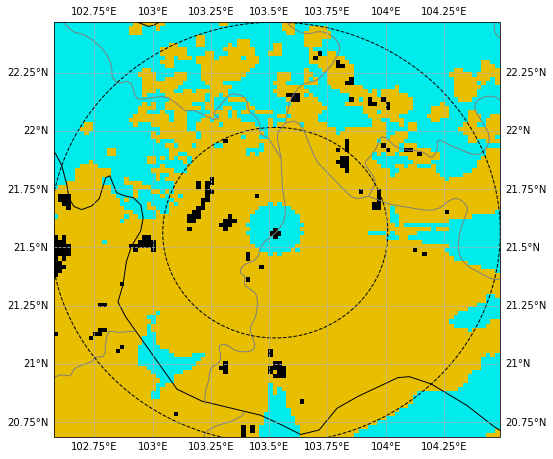

In [10]:
circle_points_50km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=50000, n_samples=180, endpoint=False)
circle_points_100km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=100000, n_samples=180, endpoint=False)
circle_points_200km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=200000, n_samples=180, endpoint=False)
geom_50km=Polygon(circle_points_50km)
geom_100km=Polygon(circle_points_100km)
geom_200km=Polygon(circle_points_200km)
lon=grid_lat_lon.x['data']
lat=grid_lat_lon.y['data']
lons,lats=np.meshgrid(lon,lat)
#plot map with datas
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeat.LAND)
ax.add_feature(cfeat.OCEAN.with_scale('10m'))
ax.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax.add_feature(state_provinces_lines,edgecolor='gray')
ax.gridlines(draw_labels=True,linestyle='--')
ax.set_extent((grid.x['data'][1],grid.x['data'][-1],grid.y['data'][1],grid.y['data'][-1]),crs=ccrs.PlateCarree())
ax.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax.pcolormesh(lons,lats,YH95,shading='flat',cmap=pyart.graph.cm.NWSRef)
ax.scatter(x=103.526,y=21.5632,transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P');